# GloVE

Let's work on implementation of GloVE.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## 1. Load data

In [2]:
import nltk
from nltk.corpus import reuters

# Define the training corpus
corpus = reuters.sents(categories="trade")

In [3]:
corpus

[['ASIAN', 'EXPORTERS', 'FEAR', 'DAMAGE', 'FROM', 'U', '.', 'S', '.-', 'JAPAN', 'RIFT', 'Mounting', 'trade', 'friction', 'between', 'the', 'U', '.', 'S', '.', 'And', 'Japan', 'has', 'raised', 'fears', 'among', 'many', 'of', 'Asia', "'", 's', 'exporting', 'nations', 'that', 'the', 'row', 'could', 'inflict', 'far', '-', 'reaching', 'economic', 'damage', ',', 'businessmen', 'and', 'officials', 'said', '.'], ['They', 'told', 'Reuter', 'correspondents', 'in', 'Asian', 'capitals', 'a', 'U', '.', 'S', '.', 'Move', 'against', 'Japan', 'might', 'boost', 'protectionist', 'sentiment', 'in', 'the', 'U', '.', 'S', '.', 'And', 'lead', 'to', 'curbs', 'on', 'American', 'imports', 'of', 'their', 'products', '.'], ...]

In [4]:
len(corpus)

4852

In [5]:
from nltk.corpus import stopwords
import string
import re

# Define stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Regular expression to match double punctuations
double_punctuation_pattern = re.compile(r'[' + re.escape(string.punctuation) + ']{2,}')

# Function to clean the corpus
def clean_corpus(corpus):
    cleaned_corpus = []
    for sentence in corpus:
        cleaned_sentence = []
        for word in sentence:
            word = word.lower()
            # Check for stopwords, punctuation, and double punctuation
            if word not in stop_words and word not in punctuation and not double_punctuation_pattern.match(word):
                cleaned_sentence.append(word)
        cleaned_corpus.append(cleaned_sentence)
    return cleaned_corpus

# Clean the corpus
corpus_tokenized = clean_corpus(corpus)
corpus_tokenized

[['asian',
  'exporters',
  'fear',
  'damage',
  'u',
  'japan',
  'rift',
  'mounting',
  'trade',
  'friction',
  'u',
  'japan',
  'raised',
  'fears',
  'among',
  'many',
  'asia',
  'exporting',
  'nations',
  'row',
  'could',
  'inflict',
  'far',
  'reaching',
  'economic',
  'damage',
  'businessmen',
  'officials',
  'said'],
 ['told',
  'reuter',
  'correspondents',
  'asian',
  'capitals',
  'u',
  'move',
  'japan',
  'might',
  'boost',
  'protectionist',
  'sentiment',
  'u',
  'lead',
  'curbs',
  'american',
  'imports',
  'products'],
 ['exporters',
  'said',
  'conflict',
  'would',
  'hurt',
  'long',
  'run',
  'short',
  'term',
  'tokyo',
  'loss',
  'might',
  'gain'],
 ['u',
  'said',
  'impose',
  '300',
  'mln',
  'dlrs',
  'tariffs',
  'imports',
  'japanese',
  'electronics',
  'goods',
  'april',
  '17',
  'retaliation',
  'japan',
  'alleged',
  'failure',
  'stick',
  'pact',
  'sell',
  'semiconductors',
  'world',
  'markets',
  'cost'],
 ['unofficia

In [6]:
len(corpus_tokenized)

4852

In [7]:
#2. numeralization
#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(flatten(corpus_tokenized))) #all the words we have in the system - <UNK>

In [8]:
len(vocabs)

7135

In [9]:
#create handy mapping between integer and word
word2index = {v:idx for idx, v in enumerate(vocabs)}
word2index

{'denmark': 0,
 'shrink': 1,
 'dupont': 2,
 'fuelled': 3,
 'materials': 4,
 'steeply': 5,
 'safe': 6,
 'presidency': 7,
 'rasmussen': 8,
 'benderley': 9,
 'tackle': 10,
 'weakness': 11,
 'felt': 12,
 'speedy': 13,
 'spending': 14,
 'wrote': 15,
 'fats': 16,
 'bundesbank': 17,
 'invoke': 18,
 'productive': 19,
 'divert': 20,
 'speculation': 21,
 'driving': 22,
 'volume': 23,
 'clearcut': 24,
 'view': 25,
 'solve': 26,
 'hosted': 27,
 'interest': 28,
 'offices': 29,
 'considerably': 30,
 'revenue': 31,
 'consumed': 32,
 'temporarily': 33,
 'withhold': 34,
 '77': 35,
 'dependency': 36,
 'tenders': 37,
 'preliminary': 38,
 'bids': 39,
 'encouraging': 40,
 'voters': 41,
 'fsc34': 42,
 'reservations': 43,
 'buoy': 44,
 'spectre': 45,
 'hoping': 46,
 'elliot': 47,
 'alter': 48,
 'function': 49,
 'oslo': 50,
 'impatient': 51,
 'neyra': 52,
 'dominated': 53,
 'louvre': 54,
 'impair': 55,
 'subsidised': 56,
 'contingency': 57,
 '136': 58,
 '904': 59,
 'sending': 60,
 'lawmaker': 61,
 'friday': 6

In [10]:
# append UNK
vocabs.append('<UNK>')
word2index['<UNK>'] = 7135

In [11]:
index2word = {v:k for k, v in word2index.items()}
index2word[7134]

'length'

In [12]:
len(word2index)

7136

In [13]:
#just in case we need to use
index2word = {v:k for k, v in word2index.items()} 

In [14]:
index2word[7135]

'<UNK>'

## 2. Build Co-occurence Matrix X

Here, we need to count the co-occurence of two words given some window size.  We gonna use window size of 1.

In [15]:
#count the frequency of each word
from collections import Counter

X_i = Counter(flatten(corpus_tokenized))
len(X_i)

7135

In [16]:
def generate_skip_gram(corpus, window_size=2):
    skip_grams = []
    
    for doc in corpus:
        for i in range(len(doc)):  # Iterate over each word in the document
            center = doc[i]  # Center word
            
            # Define the window boundaries
            start = max(0, i - window_size)  # Ensure start is not negative
            end = min(len(doc), i + window_size + 1)  # Ensure end does not exceed document length
            
            # Collect context words within the window (excluding the center word itself)
            outside = doc[start:i] + doc[i+1:end]
            
            # Create skip-gram pairs
            for each_out in outside:
                skip_grams.append((center, each_out))
    
    return skip_grams

In [17]:
#prepare skipgrams with window size of 2
skip_grams = generate_skip_gram(corpus_tokenized, 2)
skip_grams

[('asian', 'exporters'),
 ('asian', 'fear'),
 ('exporters', 'asian'),
 ('exporters', 'fear'),
 ('exporters', 'damage'),
 ('fear', 'asian'),
 ('fear', 'exporters'),
 ('fear', 'damage'),
 ('fear', 'u'),
 ('damage', 'exporters'),
 ('damage', 'fear'),
 ('damage', 'u'),
 ('damage', 'japan'),
 ('u', 'fear'),
 ('u', 'damage'),
 ('u', 'japan'),
 ('u', 'rift'),
 ('japan', 'damage'),
 ('japan', 'u'),
 ('japan', 'rift'),
 ('japan', 'mounting'),
 ('rift', 'u'),
 ('rift', 'japan'),
 ('rift', 'mounting'),
 ('rift', 'trade'),
 ('mounting', 'japan'),
 ('mounting', 'rift'),
 ('mounting', 'trade'),
 ('mounting', 'friction'),
 ('trade', 'rift'),
 ('trade', 'mounting'),
 ('trade', 'friction'),
 ('trade', 'u'),
 ('friction', 'mounting'),
 ('friction', 'trade'),
 ('friction', 'u'),
 ('friction', 'japan'),
 ('u', 'trade'),
 ('u', 'friction'),
 ('u', 'japan'),
 ('u', 'raised'),
 ('japan', 'friction'),
 ('japan', 'u'),
 ('japan', 'raised'),
 ('japan', 'fears'),
 ('raised', 'u'),
 ('raised', 'japan'),
 ('raised

In [18]:
skip_grams[:5]

[('asian', 'exporters'),
 ('asian', 'fear'),
 ('exporters', 'asian'),
 ('exporters', 'fear'),
 ('exporters', 'damage')]

In [19]:
#count co-occurences in the skipgrams
X_ik_skipgrams = Counter(skip_grams)
X_ik_skipgrams

Counter({('billion', 'dlrs'): 446,
         ('dlrs', 'billion'): 446,
         ('trade', 'u'): 291,
         ('u', 'trade'): 291,
         ('united', 'states'): 258,
         ('states', 'united'): 258,
         ('mln', 'dlrs'): 242,
         ('dlrs', 'mln'): 242,
         ('trade', 'deficit'): 240,
         ('deficit', 'trade'): 240,
         ('last', 'year'): 216,
         ('year', 'last'): 216,
         ('trade', 'surplus'): 211,
         ('surplus', 'trade'): 211,
         ('1', 'billion'): 211,
         ('billion', '1'): 211,
         ('2', 'billion'): 188,
         ('billion', '2'): 188,
         ('officials', 'said'): 137,
         ('said', 'officials'): 137,
         ('said', 'trade'): 125,
         ('trade', 'said'): 125,
         ('u', 'japan'): 120,
         ('japan', 'u'): 120,
         ('u', 'said'): 119,
         ('said', 'u'): 119,
         ('6', 'billion'): 119,
         ('billion', '6'): 119,
         ('japan', 'trade'): 116,
         ('trade', 'japan'): 116,
         (

In [20]:
len(X_ik_skipgrams)

162663

### Weighting function

GloVe includes a weighting function to scale down too frequent words.

<img src = "../figures/glove_weighting_func.png" width=400>

In [21]:
# Define the weight function
def weighting(w_i, w_j, X_ik):
    
    #check whether the co-occurences between w_i and w_j is available
    try:
        x_ij = X_ik[(w_i, w_j)]
        #if not exist, then set to 1 "laplace smoothing"
    except:
        x_ij = 1
        
    #set xmax
    x_max = 100
    #set alpha
    alpha = 0.75
    
    #if co-ocurrence does not exceeed xmax, then just multiply with some alpha
    if x_ij < x_max:
        result = (x_ij / x_max)**alpha
    #otherwise, set to 1
    else:
        result = 1
    
    return result

In [22]:
# apply this weight to all pairs
from itertools import combinations_with_replacement

X_ik = {} #keeping the co-occurences
weighting_dic = {} #already scale the co-occurences using the weighting function

for bigram in combinations_with_replacement(vocabs, 2):
    if X_ik_skipgrams.get(bigram):  #if the pair exists in our corpus
        co = X_ik_skipgrams[bigram]
        X_ik[bigram] = co + 1 #for stability
        X_ik[(bigram[1], bigram[0])] = co + 1 #basically apple, banana = banana, apple
    else:
        pass
    
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

## 3. Prepare train data

In [23]:
import math

def random_batch(batch_size, word_sequence, X_ik, weighting_dic, window_size=2):
    
    # Generate skip-grams dynamically based on window_size
    skip_grams = generate_skip_gram(word_sequence, window_size)
    
    #convert our skipgrams to id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    #randomly choose indexes based on batch size
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False)
    
    #Initialize
    random_inputs, random_labels, random_coocs, random_weightings = [], [], [], []

    #get the random input and labels
    for index in random_index:
        random_inputs.append([skip_grams_id[index][0]]) # Center word ID
        random_labels.append([skip_grams_id[index][1]]) # Context word ID
        
        # Get the co-occurrence count
        pair = skip_grams[index] #e.g., ('banana', 'fruit')
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
    
        #weightings
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
        
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

### Testing the method

In [24]:
batch_size = 2
x, y, cooc, weighting = random_batch(batch_size, corpus_tokenized, X_ik, weighting_dic, 2)

In [25]:
x

array([[6476],
       [4898]])

In [26]:
y

array([[6700],
       [6669]])

In [27]:
cooc

array([[2.63905733],
       [1.09861229]])

In [28]:
weighting

array([[0.22887377],
       [0.07208434]])

## 4. Model

<img src ="../figures/glove.png" width=400>

In [29]:
class Glove(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Glove, self).__init__()
        self.center_embedding  = nn.Embedding(voc_size, emb_size)
        self.outside_embedding = nn.Embedding(voc_size, emb_size)
        
        self.center_bias       = nn.Embedding(voc_size, 1) 
        self.outside_bias      = nn.Embedding(voc_size, 1)
    
    def forward(self, center, outside, coocs, weighting):
        center_embeds  = self.center_embedding(center) #(batch_size, 1, emb_size)
        outside_embeds = self.outside_embedding(outside) #(batch_size, 1, emb_size)
        
        center_bias    = self.center_bias(center).squeeze(1)
        target_bias    = self.outside_bias(outside).squeeze(1)
        
        inner_product  = outside_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1)
        
        loss = weighting * torch.pow(inner_product + center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

## 5. Training

In [30]:
import time

#calculate epoch time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time // 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [31]:
# Check if CUDA is available and use GPU if yes
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
else:
    device = torch.device("cpu")   # Use CPU

In [32]:
# Set Training Parameters
window_size = 5
batch_size  = 256
emb_size    = 50
voc_size    = len(vocabs)

model          = Glove(voc_size, emb_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
#train the model
num_epochs = 1000
start = time.time()

for epoch in range(num_epochs):
    
    #get batch
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus_tokenized, X_ik, weighting_dic, window_size)
    input_batch  = torch.LongTensor(input_batch).to(device)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch).to(device)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch).to(device)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch).to(device) #[batch_size, 1]
    
    optimizer.zero_grad()
    loss = model(input_batch, target_batch, cooc_batch, weighting_batch)
    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    if (epoch + 1) % 100 == 0:
        epoch_mins, epoch_secs = epoch_time(start, end)
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f} | time: {epoch_mins}m {epoch_secs}s")


Epoch    100 | Loss: 1421.654785 | time: 0m 21s
Epoch    200 | Loss: 1384.330566 | time: 0m 43s
Epoch    300 | Loss: 1284.730957 | time: 1m 5s
Epoch    400 | Loss: 1288.284790 | time: 1m 29s
Epoch    500 | Loss: 876.173279 | time: 1m 48s
Epoch    600 | Loss: 846.275452 | time: 2m 7s
Epoch    700 | Loss: 737.325623 | time: 2m 26s
Epoch    800 | Loss: 754.521057 | time: 2m 44s
Epoch    900 | Loss: 752.853027 | time: 3m 3s
Epoch   1000 | Loss: 597.154785 | time: 3m 22s


**Total training time for Glove from Scratch is 3 minutes 23 seconds**

## 6. Plotting the embeddings

In [34]:
len(vocabs)

7136

In [35]:
word = vocabs[0]
word

'denmark'

In [36]:
#numericalization
id = word2index[word]
id

0

In [37]:
id_tensor = torch.LongTensor([id]).to(device)
id_tensor

tensor([0], device='cuda:0')

In [38]:
#get the embedding by averaging
v_embed = model.center_embedding(id_tensor).to(device)
u_embed = model.outside_embedding(id_tensor).to(device)

v_embed, u_embed

(tensor([[ 1.7313e+00,  4.2660e-01,  1.3693e+00, -1.7386e+00,  3.4328e-01,
           3.1631e-01, -5.6112e-01, -5.5964e-01,  1.4930e+00,  1.6808e+00,
           3.0110e+00,  1.7927e-01,  8.4166e-01, -4.3475e-01,  3.1967e-01,
           1.3693e-01,  7.4725e-01,  1.4860e-01,  2.3127e+00, -2.7793e-01,
           3.3648e-01,  1.7492e-01, -1.2853e+00,  7.2644e-01, -5.8655e-01,
           2.3120e+00,  2.3895e-01,  5.8069e-01,  9.9637e-01,  1.2784e+00,
           1.2258e+00, -5.9726e-01,  2.4285e-03,  7.1988e-01,  1.8461e+00,
           1.6614e+00, -2.7221e-01, -1.1005e+00,  2.6658e-01, -7.5228e-01,
           1.1375e+00, -2.5024e+00,  1.4657e+00,  3.0014e+00,  4.4675e-01,
          -6.1878e-01, -4.6697e-01,  7.3153e-01,  4.2591e-01, -7.3663e-01]],
        device='cuda:0', grad_fn=<EmbeddingBackward0>),
 tensor([[-0.2913,  1.2407, -0.9409,  0.5842, -0.3253,  0.6648,  1.1911, -0.0043,
          -1.8570,  0.2786,  0.6996,  0.4811, -0.9787,  0.7724,  0.9625,  1.4667,
          -0.4959, -0.3273, 

In [39]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed

tensor([[ 0.7200,  0.8337,  0.2142, -0.5772,  0.0090,  0.4905,  0.3150, -0.2820,
         -0.1820,  0.9797,  1.8553,  0.3302, -0.0685,  0.1688,  0.6411,  0.8018,
          0.1257, -0.0894,  0.5729, -0.2601,  0.6613,  0.6781, -1.4774,  0.7014,
          0.4540,  0.7886,  0.0404,  0.6077,  0.0158,  0.6362,  0.5709, -0.4145,
         -0.5089,  0.4374,  0.8766,  0.6237, -0.5788, -0.3105, -0.5488, -0.1791,
          0.9831, -0.7628,  1.2761,  1.1405,  0.8657, -0.3680,  0.4578,  0.4147,
          0.1497, -0.1604]], device='cuda:0', grad_fn=<DivBackward0>)

In [40]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]]).to(device)
    v_embed = model.center_embedding(id_tensor).to(device)
    u_embed = model.outside_embedding(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

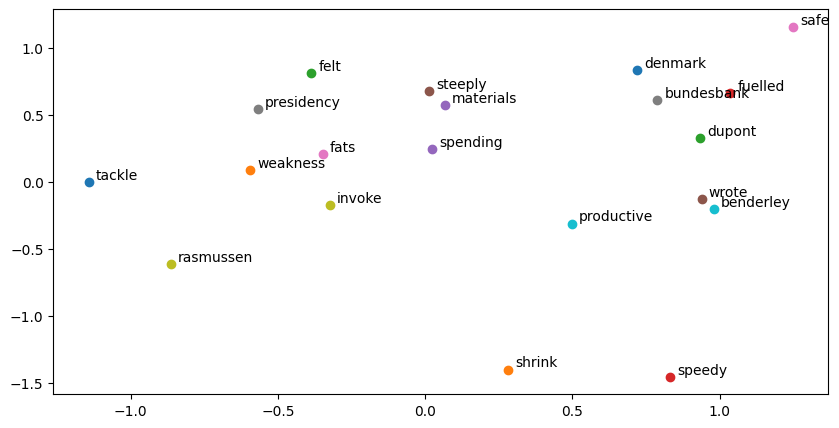

In [41]:
plt.figure(figsize=(10, 5))
for i, word in enumerate(vocabs[:20]):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

In [42]:
#save the GloVe model with pickle
import pickle

pickle.dump(model, open('../../models/Glove_from_scratch.model', 'wb'))

In [43]:
#save the GloVe model with torch
import torch
torch.save(model.state_dict(), '../../models/Glove_from_scratch.pt')